# NHP7 - Non-human primate data visualize task block structure (exploratory subject only)

## Takuya Ito
#### 12/7/2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import sys
import h5py
import statsmodels.api as sm
import analysisNHP as analysis


# Set up data parameters

In [2]:
## All sessions (both subjects included)
sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
            '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
            '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
            '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
            '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
            '101030','101127','101206','101216','110107_02','110111_02']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing

# Load in monkeyIDs
idfile = datadir + 'monkeyToSessionID.csv'
monkeyTable = pd.read_csv(idfile,delimiter=',')

replication_sessions = 0
monkeyID = {}
for i in range(1, len(sessions)+1):
    if i < 10:
        sess_str = 'session_ ' + str(i)
        name_str = 'name_ '  + str(i)
    else:
        sess_str = 'session_' + str(i)
        name_str = 'name_'  + str(i)
    
    session = str(monkeyTable[sess_str][0])
    name = monkeyTable[name_str][0]

    if name=='paula':
        replication_sessions += 1
        
    if session=='110111_02.mat': session = '110111_02'
        
    monkeyID[session] = name
    
exploratory_sessions = len(sessions) - replication_sessions
print 'Number of sessions with exploratory subject:', exploratory_sessions 
print 'Number of sessions with replication subject', replication_sessions
    
regions = ['PFC', 'FEF', 'LIP', 'MT', 'IT', 'V4']

Number of sessions with exploratory subject: 16
Number of sessions with replication subject 39


# 1.0 Load all sessions for exploratory subject

#### Load other meta-data associated with neurons + task info

#### Compute downsampled firing rate using 50ms bins and 10ms shift

# Perform main analyses for exploratory subject

In [100]:
# session = '101127'
session = '110107_01'
taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
mocolTrials = np.where(taskInfo['task']=='mocol')[0]
mocolInfo = pd.read_csv(datadir + session + '_trialInfoMOCOL.csv')
areas = pd.read_csv(datadir + session + '_areaIndices_v2.csv')
h5f = h5py.File(datadir + session + '_perArea_v2.h5', 'r')
roi = 6
task = 'motion'

# Identify trials for specific task condition
tasksByTrial = mocolInfo['rule'].astype(str)
task_ind = np.where(tasksByTrial==task)[0]
correct_ind = np.where(mocolInfo.correct==1)[0]
task_ind = np.intersect1d(task_ind,correct_ind)

# Columns for h5f are reversed between matlab and python
spikes_binned = analysis.slidingWindow(h5f['sta'][mocolTrials,:,roi].T,binSize=50,shiftSize=10)

tmin = -4000
tmax = 4000
time = np.linspace(tmin,tmax,spikes_binned.shape[0])

# Calculate mean-evoked response, and remove it from each trial
duration = 50
sta_removed = []
data = []

staByTask = np.mean(spikes_binned[:,task_ind],axis=1)
i = 0
for ind in task_ind:
    # First make sure there are enough time points during the ITI period for this analysis
    if np.mean(spikes_binned[:,ind])==0:
        continue
    ## First identify the beginning of recording (prior to taskStart)
    iti_onset = np.min(np.where(spikes_binned[:,ind]!=0)[0])+5
    #preStimStart = np.min(np.where(time>=df['mocolInfo'][session_ind]['fixptOn'][trial]*1000)[0])
    try:
        #preStimEnd= np.max(np.where(time<df['mocolInfo'][session_ind]['cueOn'][trial]*1000)[0])
        iti_offset = np.max(np.where(time<mocolInfo.fixptOn[ind]*1000)[0]) # Convert trial start times to ms
    except:
        continue
    nTPs = iti_offset - iti_onset
    if nTPs<duration:
        continue
    else:
        iti_offset = iti_onset + duration
        
        
    # Identify task cue onset 
    cue_onset = np.min(np.where(time>=mocolInfo.cueOn[ind]*1000)[0])
    
    cue_offset = cue_onset + duration
    precue_onset = cue_onset - duration
    
    data_array = np.zeros((duration*2,))
    i = 0
    data_array[:duration] = spikes_binned[iti_onset:iti_offset,ind]
    i += duration
#     data_array[i:i+duration] = spikes_binned[precue_onset:cue_onset,ind]
#     i += duration
    data_array[i:] = spikes_binned[cue_onset:cue_offset,ind]
    
    data.append(data_array)

data = np.asarray(data).T
# Calculate event-triggered average
staByTask = np.mean(data,axis=1)

tmpmean = staByTask.copy()
tmpmean.shape = (len(tmpmean),1)

sta_removed = data - tmpmean

h5f.close()

###
trial_periods = {}
trial_periods['Timepoint'] = []
trial_periods['Rate'] = []
trial_periods['Trial'] = []
trial_periods['State'] = []
trial_avg = []
ntps = data.shape[0]
ntrials = data.shape[1]
for i in range(ntrials):
    for tp in range(ntps):
        if tp<duration:
            state='ITI'
#         elif duration<tp<duration*2:
#             state='Fixation'
        elif tp>duration:
            state='Task'
        trial_periods['Trial'].append(i+1)
        trial_periods['State'].append(state)
        trial_periods['Timepoint'].append(tp)
        trial_periods['Rate'].append(data[tp,i])

df_mean = pd.DataFrame(trial_periods)
data_avg = np.mean(data,axis=0)

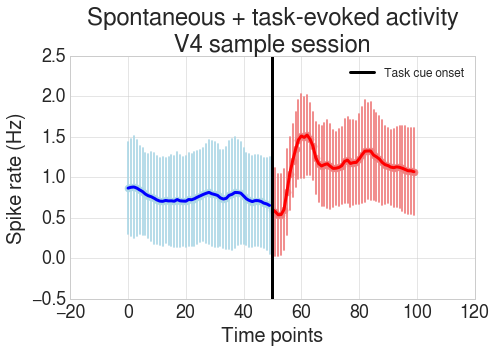

In [122]:
df_iti = df_mean.loc[df_mean.State=='ITI']
# df_fix = df_mean.loc[df_mean.State=='Fixation']
df_task = df_mean.loc[df_mean.State=='Task']
plt.figure(figsize=(7,5));
sns.regplot(x="Timepoint", y="Rate", data=df_iti, color='#add8e6', x_ci='sd', x_estimator=np.mean,fit_reg=False);
sns.regplot(x="Timepoint", y="Rate", data=df_task, color='#f08080', x_ci='sd', x_estimator=np.mean,fit_reg=False);
x = np.arange(ntps)
plt.plot(x[:duration],staByTask[:duration],'blue',linewidth=3)
plt.plot(x[duration:],staByTask[duration:],'r',linewidth=3)
plt.axvline(x=duration,color='k',linewidth=3,label='Task cue onset');
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('Spike rate (Hz)',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Spontaneous + task-evoked activity\nV4 sample session',fontsize=24);
plt.tight_layout()
plt.savefig('NHP7b_TaskDynamics_Example.jpg',dpi=150)


# Remove mean signal

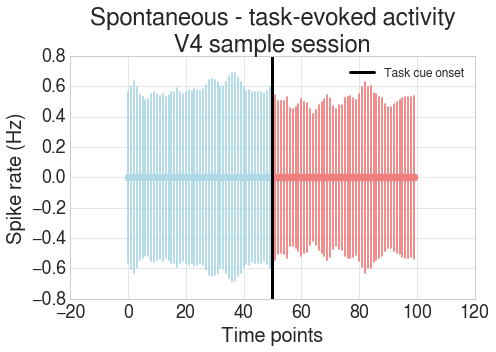

In [123]:
trial_nomean = {}
trial_nomean['Timepoint'] = []
trial_nomean['Rate'] = []
trial_nomean['Trial'] = []
trial_nomean['State'] = []
ntps = data.shape[0]
ntrials = data.shape[1]
for i in range(ntrials):
    for tp in range(ntps):
        if tp<duration:
            state='ITI'
#         elif duration<tp<duration*2:
#             state='Fixation'
        elif tp>duration:
            state='Task'
        trial_nomean['Trial'].append(i+1)
        trial_nomean['State'].append(state)
        trial_nomean['Timepoint'].append(tp)
        trial_nomean['Rate'].append(data[tp,i]-staByTask[tp])

df_nomean = pd.DataFrame(trial_nomean)
df_iti = df_nomean.loc[df_nomean.State=='ITI']
# df_fix = df_nomean.loc[df_nomean.State=='Fixation']
df_task = df_nomean.loc[df_nomean.State=='Task']
plt.figure(figsize=(7,5));
sns.regplot(x="Timepoint", y="Rate", data=df_iti, color='#add8e6', x_ci='sd', x_estimator=np.mean,fit_reg=False);
sns.regplot(x="Timepoint", y="Rate", data=df_task, color='#f08080', x_ci='sd', x_estimator=np.mean,fit_reg=False);
plt.axvline(x=duration,color='k',linewidth=3,label='Task cue onset');
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('Spike rate (Hz)',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Spontaneous - task-evoked activity\nV4 sample session',fontsize=24);
plt.tight_layout()
plt.savefig('NHP7b_TaskDynamics_NoMean_Example.jpg',dpi=150)

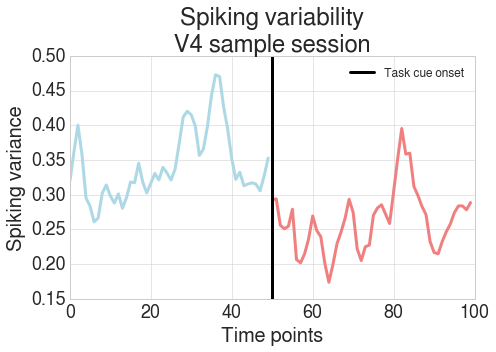

In [124]:
plt.figure(figsize=(7,5));
# sns.regplot(x="Time point", y="Spike rate", data=df_nomean, x_ci='sd', x_estimator=np.mean,fit_reg=False);
trialvar = np.var(data,axis=1)
# plt.plot(np.var(data,axis=1),'k',linewidth=3)
plt.plot(x[:duration],trialvar[:duration],color='#add8e6',linewidth=3)
plt.plot(x[duration:],trialvar[duration:],'#f08080',linewidth=3)
plt.axvline(x=duration,color='k',linewidth=3,label='Task cue onset');
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('Spiking variance',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Spiking variability\nV4 sample session',fontsize=24);
plt.tight_layout()
plt.savefig('NHP7b_TaskDynamics_SpikingVariability_Example.jpg',dpi=150)